<a href="https://colab.research.google.com/github/OrukamiTensey/HomeCredit/blob/main/HomeCredit_EDA_and_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk — EDA and Baseline Classifier


In [26]:
!pip install -q lightgbm category_encoders


In [27]:
DATA_DIR = '/content/sample_data'
TRAIN_PATH = f"{DATA_DIR}/application_train.csv"
TEST_PATH = f"{DATA_DIR}/application_test.csv"
SAMPLE_SUB_PATH = f"{DATA_DIR}/sample_submission.csv"

import os, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [28]:
# Завантажимо дані
print('Loading data...')
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
print('Train shape:', train.shape)
print('Test shape:', test.shape)


Loading data...
Train shape: (307511, 122)
Test shape: (48744, 121)


In [29]:

display(train.head())
print('\nTarget distribution:')
print(train['TARGET'].value_counts(normalize=True))


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [30]:
# Функція зведення пропусків
def missing_summary(df):
    miss = df.isna().mean().sort_values(ascending=False)
    return pd.DataFrame({'missing_fraction': miss, 'missing_count': (miss * len(df)).astype(int)})

print('Train missing summary (top 20):')
display(missing_summary(train).head(20))
print('\nTest missing summary (top 20):')
display(missing_summary(test).head(20))


cat_cols = [c for c in train.columns if train[c].dtype == 'object']
num_cols = [c for c in train.columns if c not in cat_cols and c != 'TARGET']
print('\n#categorical:', len(cat_cols), ' #numeric:', len(num_cols))
print('\nTarget counts:')
print(train['TARGET'].value_counts())


Train missing summary (top 20):


,missing_fraction,missing_count
COMMONAREA_AVG,0.698723,214865
COMMONAREA_MODE,0.698723,214865
COMMONAREA_MEDI,0.698723,214865
NONLIVINGAPARTMENTS_MEDI,0.694330,213514
NONLIVINGAPARTMENTS_MODE,0.694330,213514
NONLIVINGAPARTMENTS_AVG,0.694330,213514
FONDKAPREMONT_MODE,0.683862,210295
LIVINGAPARTMENTS_AVG,0.683550,210199
LIVINGAPARTMENTS_MEDI,0.683550,210199
LIVINGAPARTMENTS_MODE,0.683550,210199



Test missing summary (top 20):


,missing_fraction,missing_count
COMMONAREA_AVG,0.687161,33495
COMMONAREA_MEDI,0.687161,33495
COMMONAREA_MODE,0.687161,33495
NONLIVINGAPARTMENTS_AVG,0.684125,33347
NONLIVINGAPARTMENTS_MEDI,0.684125,33347
NONLIVINGAPARTMENTS_MODE,0.684125,33347
FONDKAPREMONT_MODE,0.672842,32797
LIVINGAPARTMENTS_MEDI,0.672493,32780
LIVINGAPARTMENTS_AVG,0.672493,32780
LIVINGAPARTMENTS_MODE,0.672493,32780



#categorical: 16  #numeric: 105

Target counts:
TARGET
0    282686
1     24825
Name: count, dtype: int64


In [31]:
# Порівняємо колонки між навчальним і тестовим наборами
rep_cols = ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CODE_GENDER']
for c in rep_cols:
    if c in train.columns:
        print('\nColumn:', c)
        if train[c].dtype == 'object':
            print('Train top frequencies:')
            print(train[c].value_counts(normalize=True).head(10))
            print('Test top frequencies:')
            print(test[c].value_counts(normalize=True).head(10))
        else:
            print('Train describe:')
            print(train[c].describe())
            print('Test describe:')
            print(test[c].describe())



Column: AMT_CREDIT
Train describe:
count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
Test describe:
count    4.874400e+04
mean     5.167404e+05
std      3.653970e+05
min      4.500000e+04
25%      2.606400e+05
50%      4.500000e+05
75%      6.750000e+05
max      2.245500e+06
Name: AMT_CREDIT, dtype: float64

Column: AMT_INCOME_TOTAL
Train describe:
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
Test describe:
count    4.874400e+04
mean     1.784318e+05
std      1.015226e+05
min      2.694150e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.250000e+05
max      4.410000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

Column: DAYS_BIRTH
Train describe:
count   

In [32]:
# Вибір ознак та проста стратегія попередньої обробки даних
DROP_COLS = ['SK_ID_CURR']
X = train.drop(columns=['TARGET'] + DROP_COLS)
y = train['TARGET']
X_test = test.drop(columns=DROP_COLS)

num_feats = [c for c in X.select_dtypes(include=[np.number]).columns if X[c].isna().mean() < 0.4]
cat_feats = [c for c in X.select_dtypes(include=['object']).columns]

print('Selected numeric features (count):', len(num_feats))
print('Selected categorical features (count):', len(cat_feats))

low_card = [c for c in cat_feats if X[c].nunique() <= 20]
high_card = [c for c in cat_feats if X[c].nunique() > 20]
print('Low-card categorical:', len(low_card), 'High-card categorical:', len(high_card))

from sklearn.pipeline import Pipeline
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
cat_onehot = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

for c in high_card:
    freq = X[c].value_counts(normalize=True)
    X[c + '_freq_enc'] = X[c].map(freq)
    X_test[c + '_freq_enc'] = X_test[c].map(freq).fillna(0)
high_card_encoded = [c + '_freq_enc' for c in high_card]

num_feats_plus = num_feats + high_card_encoded
selected_cols = num_feats_plus + low_card
print('Total numeric-like features used:', len(num_feats_plus))


Selected numeric features (count): 59
Selected categorical features (count): 16
Low-card categorical: 15 High-card categorical: 1
Total numeric-like features used: 60


In [33]:
# Підготуємо датасет для моделювання
X_proc = X.copy().replace([np.inf, -np.inf], np.nan)
X_proc = X_proc[selected_cols]
X_test_proc = X_test[selected_cols].copy()

for c in low_card:
    if c in X_test_proc.columns:
        X_test_proc[c] = X_test_proc[c].fillna(X_proc[c].mode().iloc[0])

X_train, X_val, y_train, y_val = train_test_split(X_proc, y, test_size=0.2, random_state=42, stratify=y)
print('Shapes:', X_train.shape, X_val.shape, X_test_proc.shape)


Shapes: (246008, 75) (61503, 75) (48744, 75)


In [34]:
# --- Визначимо числові та категоріальні колонки ---

num_feats_plus = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_feats = X_train.select_dtypes(include=['object']).columns.tolist()

low_card = [c for c in cat_feats if X_train[c].nunique() < 20]
high_card = [c for c in cat_feats if X_train[c].nunique() >= 20]

print("Кількість числових колонок:", len(num_feats_plus))
print("Кількість текстових колонок:", len(cat_feats))
print("Колонки з малою кількістю унікальних значень:", low_card[:10])

Кількість числових колонок: 60
Кількість текстових колонок: 15
Колонки з малою кількістю унікальних значень: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_onehot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats_plus),
    ('onehot', cat_onehot, low_card)
], remainder='drop')

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# --- RandomForest ---
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(
    n_estimators=50, n_jobs=-1, random_state=42)
)
rf_pipe.fit(X_train, y_train)
y_val_pred = rf_pipe.predict_proba(X_val)[:, 1]
print('🌲 RandomForest Validation ROC_AUC:', roc_auc_score(y_val, y_val_pred))

# --- LogisticRegression ---
log_pipe = make_pipeline(preprocessor,
                         StandardScaler(with_mean=False),
                         LogisticRegression(max_iter=1000))
log_pipe.fit(X_train, y_train)
y_val_pred_log = log_pipe.predict_proba(X_val)[:, 1]
print('📈 Logistic Regression Validation ROC_AUC:', roc_auc_score(y_val, y_val_pred_log))


KeyboardInterrupt: 

In [ ]:
best_model = log_pipe

# Навчаємо на всьому train
best_model.fit(X_train, y_train)

# Передбачення на тестовому наборі
y_test_pred = best_model.predict_proba(X_test)[:, 1]

# Створюємо submission
submission = pd.read_csv(SAMPLE_SUB_PATH)
submission['TARGET'] = y_test_pred
submission.to_csv('homecredit_submission.csv', index=False)
print("Submission saved: homecredit_submission.csv")

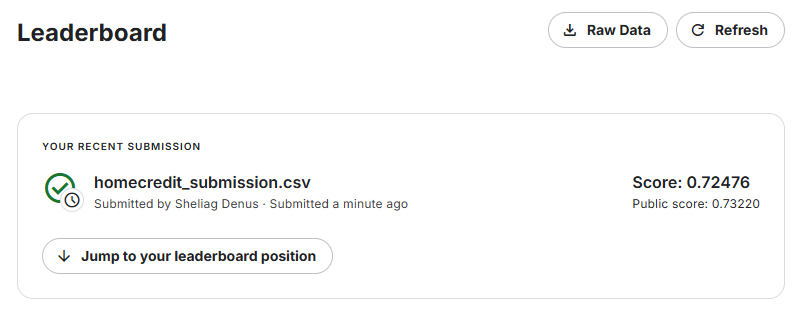